In [1]:
%load_ext autoreload
%autoreload 2

# general
from pathlib import Path
import numpy as np

# regridding
import xarray as xa
import xesmf
# import cf-python
import pyproj
import rioxarray
import rasterio
import pyresample

# aesthetics
import matplotlib.pyplot as plt
import plotting
import utils
import cartopy.crs as ccrs

In [121]:
# general bounds
LATS = [-15, -10]
LONS = [140, 145]
WHOLE_LATS = [-32, 0]
WHOLE_LONS = [140, 170]

# Load and visualise example datasets

In [310]:
# TODO: config file
data_dir_fp = Path("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data")
regridding_data_dir_fp = data_dir_fp / "regridding"
# bathymetry (high-resolution)
bathymetry_fp = regridding_data_dir_fp / "bathymetry" / "gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
# cmip6 (low-resolution)
cmip_fp = regridding_data_dir_fp / "cmip" / "tos_N0_S-32_W130_E170_sfc_ll_195000-204912.nc"
# unep 
unep_fp = data_dir_fp / "gdcr" / "unep_0-004_N0_S-40_W130_E170.nc"

# open datasets
unep_xa = xa.open_dataset(unep_fp)
unep_xa_lim = unep_xa["unep_coral_presence"].sel(longitude=slice(min(LONS), max(LONS)), latitude=slice(min(LATS), max(LATS)))
bathymetry_xa = xa.open_dataset(bathymetry_fp)
cmip_xa = xa.open_dataset(cmip_fp)

# adjust dataset range
whole_unep_xa = utils.process_xa_d(xa.open_dataset(unep_fp)["unep_coral_presence"].sel(longitude=slice(min(WHOLE_LONS), max(WHOLE_LONS)), latitude=slice(min(WHOLE_LATS), max(WHOLE_LATS))))
whole_cmip_xa = utils.process_xa_d(xa.open_dataset(cmip_fp)["tos"]).sel(longitude=slice(min(WHOLE_LONS), max(WHOLE_LONS)), latitude=slice(min(WHOLE_LATS), max(WHOLE_LATS))).isel(time=0)
whole_bathymetry_xa = utils.process_xa_d(xa.open_dataset(bathymetry_fp)["elevation"]).sel(longitude=slice(min(WHOLE_LONS), max(WHOLE_LONS)), latitude=slice(min(WHOLE_LATS), max(WHOLE_LATS)))

# example datasets
lr_xa = xa.DataArray(np.random.rand(20, 20), dims=["latitude", "longitude"], coords={"latitude": np.linspace(0, 5, 20), "longitude": np.linspace(0, 5, 20)}).rio.write_crs("EPSG:4326")
hr_xa = xa.DataArray(np.random.rand(400, 400), dims=["latitude", "longitude"], coords={"latitude": np.linspace(0, 5, 400), "longitude": np.linspace(0, 5, 400)}).rio.write_crs("EPSG:4326")

In [214]:
hr_xa

<xarray.DataArray (latitude: 400, longitude: 400)> Size: 1MB
array([[0.9667693 , 0.89243959, 0.52416188, ..., 0.62963199, 0.71008188,
        0.20523228],
       [0.97922313, 0.2981485 , 0.71654278, ..., 0.50057518, 0.87198413,
        0.61195455],
       [0.77238786, 0.7761402 , 0.19168568, ..., 0.22979225, 0.54528829,
        0.90137397],
       ...,
       [0.99216023, 0.42304856, 0.80457016, ..., 0.94618235, 0.68123231,
        0.63644382],
       [0.04563344, 0.19214912, 0.9275773 , ..., 0.25638808, 0.84953277,
        0.78427781],
       [0.86547799, 0.65193245, 0.18002084, ..., 0.0011466 , 0.70614903,
        0.175142  ]])
Coordinates:
  * latitude     (latitude) float64 3kB 90.0 90.01 90.03 ... 94.97 94.99 95.0
  * longitude    (longitude) float64 3kB 180.0 180.0 180.0 ... 185.0 185.0 185.0
    spatial_ref  int64 8B 0

(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'tos at 0.2500° (~27118 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x16fd77230>)

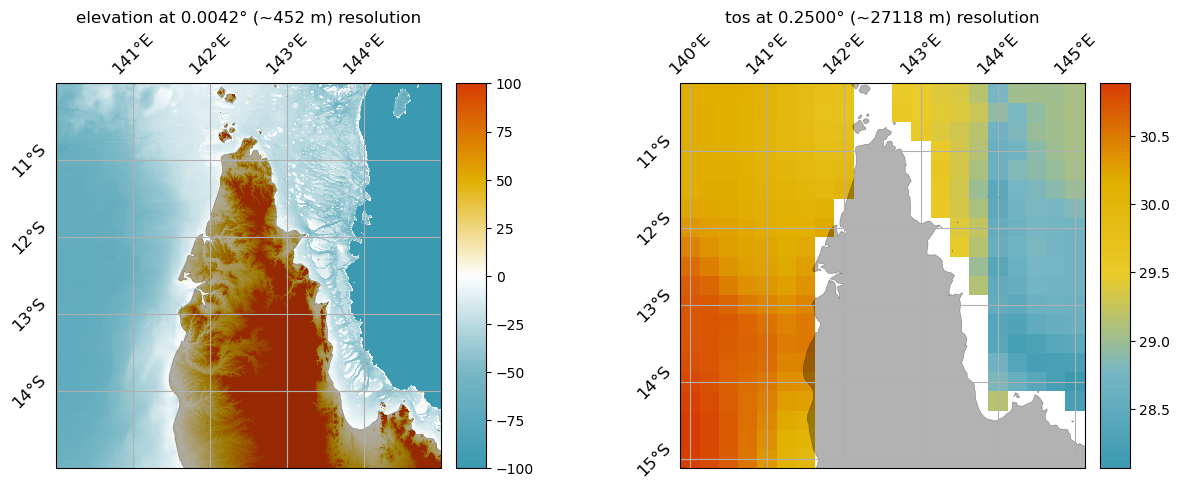

In [6]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(hr_xa.elevation, fax=(f,a[0]), cbar_dict={"cmap_type": "div"}, val_lims=[-100,100])
plotting.plot_spatial(lr_xa.tos, fax=(f,a[1]))

# xESMF

Useful: https://xesmf.readthedocs.io/en/stable/large_problems_on_HPC.html#creating-weights-on-hpc-and-using-them-in-xesmf

In [7]:
def xesmf_regrid(
    xa_d: xa.DataArray | xa.Dataset,
    lat_range: list[float] = None,
    lon_range: list[float] = None,
    resolution: float = 0.1,
    resampled_method: str = "bilinear",
):

    lon_range = sorted(lon_range)
    lat_range = sorted(lat_range)
    target_grid = xesmf.util.grid_2d(
        lon_range[0],
        lon_range[1],
        resolution,
        lat_range[0],
        lat_range[1],
        resolution,  # longitude range and resolution
    )  # latitude range and resolution

    # xa_d = xa_d.chunk({"latitude": 100, "longitude": 100})

    regridder = xesmf.Regridder(
        xa_d.astype("float64", order="C"),
        target_grid.chunk({"y": 100, "x": 100, "y_b": 100, "x_b": 100}),
        method=resampled_method,
        parallel=True,
    )

    # return spatial_data.process_xa_d(regridder(xa_d))
    return process_xesmf_regridded(regridder(xa_d.astype("float64", order="C")))
    # return regridder(xa_d.astype("float64", order="C"))


def process_xesmf_regridded(
    xa_d: xa.DataArray | xa.Dataset,
):
    if isinstance(xa_d, xa.DataArray):
        xa_d = xa_d.to_dataset(name="var_name")

    xa_d["lon"] = xa_d.lon.values[0, :]
    xa_d["lat"] = xa_d.lat.values[:, 0]

    return xa_d.rename(
        {"x": "longitude", "y": "latitude", "lon": "longitude", "lat": "latitude"}
    )

In [8]:
# upsample
hr_xa_upsampled = xesmf_regrid(hr_xa, lat_range=LATS, lon_range=LONS, resolution=0.25)

[WARNING] yaksa: 10 leaked handle pool objects


In [9]:
hr_xa_upsampled

<xarray.Dataset> Size: 4kB
Dimensions:    (latitude: 20, longitude: 20)
Coordinates:
    crs        int64 8B 0
  * longitude  (longitude) float64 160B 140.1 140.4 140.6 ... 144.4 144.6 144.9
  * latitude   (latitude) float64 160B -14.88 -14.62 -14.38 ... -10.38 -10.12
Data variables:
    elevation  (latitude, longitude) float64 3kB -58.0 -54.0 ... -1.551e+03
Attributes:
    regrid_method:  bilinear

(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.2500° (~27118 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x2b8f1fd70>)

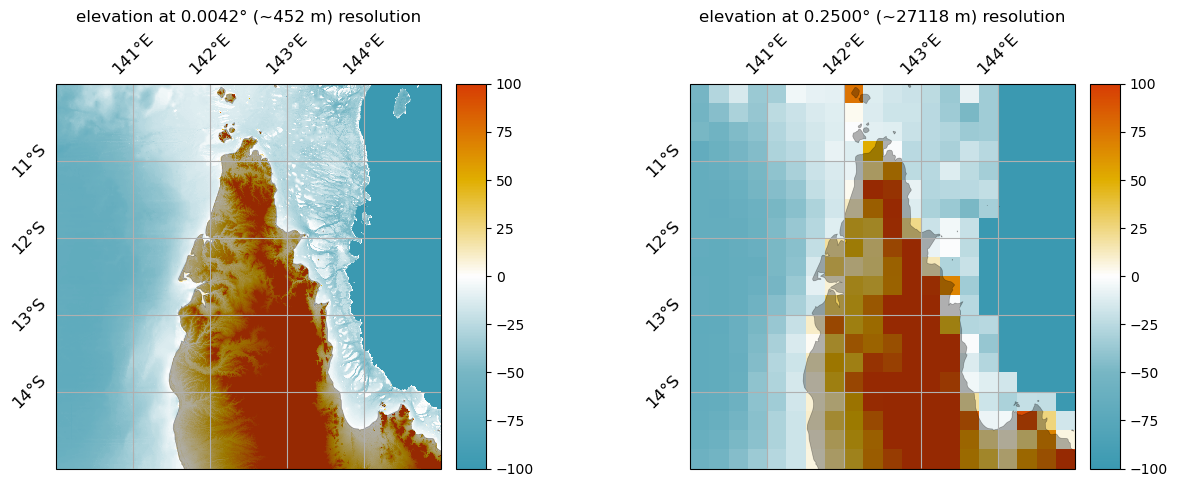

In [10]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(hr_xa.elevation, fax=(f,a[0]), cbar_dict={"cmap_type": "div"}, val_lims=[-100,100])
plotting.plot_spatial(hr_xa_upsampled.elevation, fax=(f,a[1]), cbar_dict={"cmap_type": "div"}, val_lims=[-100,100])

### Coral

In [11]:
unep_xa

<xarray.DataArray 'unep_coral_presence' (latitude: 1200, longitude: 1200)> Size: 1MB
[1440000 values with dtype=uint8]
Coordinates:
  * latitude   (latitude) float64 10kB -15.0 -14.99 -14.99 ... -10.01 -10.0
  * longitude  (longitude) float64 10kB 140.0 140.0 140.0 ... 145.0 145.0 145.0
Attributes:
    crs:      EPSG:4326

[WARNING] yaksa: 10 leaked handle pool objects


(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'var_name at 0.2500° (~27118 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x2b902efc0>)

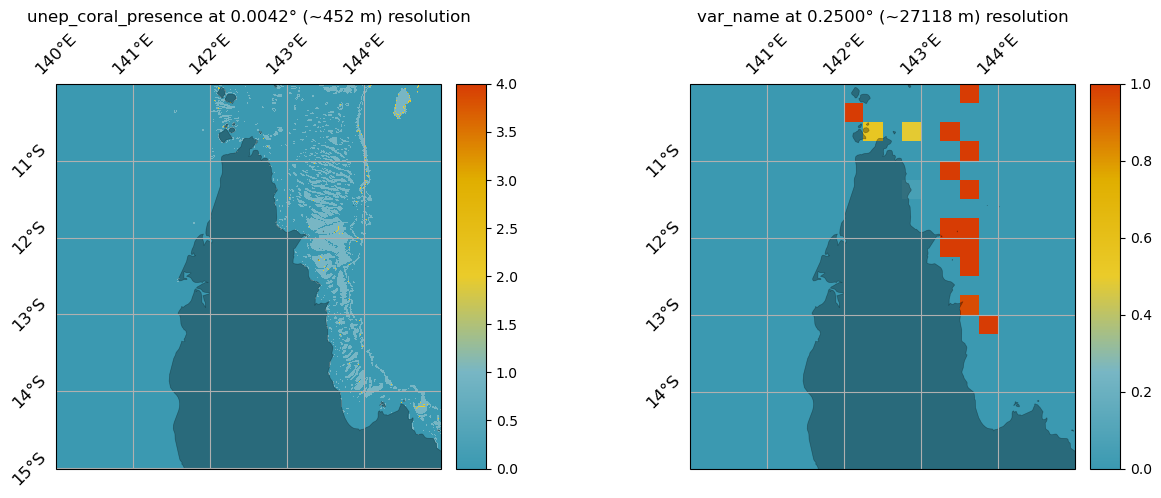

In [12]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(unep_xa, fax=(f,a[0]), cbar_dict={"cmap_type": "seq"})
plotting.plot_spatial(xesmf_regrid(unep_xa, lat_range=LATS, lon_range=LONS, resolution=0.25)["var_name"], fax=(f,a[1]), cbar_dict={"cmap_type": "seq"})

# Rasterio + rioxarray

In [13]:
hr_rio_xa = utils.process_xa_d(rioxarray.open_rasterio(bathymetry_fp)).sel(longitude=slice(min(LONS), max(LONS)), latitude=slice(min(LATS), max(LATS))).rio.set_crs("EPSG:4326")
lr_rio_xa = utils.process_xa_d(rioxarray.open_rasterio(cmip6_fp)).isel(time=0).sel(longitude=slice(min(LONS), max(LONS)), latitude=slice(min(LATS), max(LATS))).rio.set_crs("EPSG:4326")

## Downsampling

In [14]:
lr_rio_xa.rio.resolution()

(0.25, -0.25)

In [67]:
from rasterio.enums import Resampling

def calc_scale_factor(initial_resolution, final_resolution):
    return initial_resolution / final_resolution

def scaled_width_height(lat_scale_factor, lon_scale_factor, initial_width, initial_height):
    return round(initial_width * lon_scale_factor), round(initial_height * lat_scale_factor)

def resample_rasterio(rio_xa, lat_resolution, lon_resolution, resampling_method=Resampling.bilinear):
    lat_scale_factor = calc_scale_factor(abs(rio_xa.rio.resolution()[0]), lat_resolution)
    lon_scale_factor = calc_scale_factor(abs(rio_xa.rio.resolution()[1]), lon_resolution)

    new_width, new_height = scaled_width_height(lat_scale_factor, lon_scale_factor, rio_xa.rio.width, rio_xa.rio.height)
    if new_width == 0 or new_height == 0:
        raise ValueError(f"Cannot resample to 0 width or height. width: {new_width}, height: {new_height}")
    return rio_xa.rio.reproject(
        rio_xa.rio.crs,
        # resolution=final_resolution,  # both possible, but specifying resolution doesn't always work for some reason
        shape=(new_height, new_width),
        resampling=resampling_method,
    )

def process_resample_rasterio(rio_xa, lat_resolution, lon_resolution, resampling_method=Resampling.bilinear):
    return utils.process_xa_d(resample_rasterio(rio_xa, lat_resolution, lon_resolution, resampling_method))


def resample_to_other(rio_xa, other_rio_xa, resampling_method=Resampling.bilinear):
    final_lat_resolution = abs(other_rio_xa.rio.resolution()[0])
    final_lon_resolution = abs(other_rio_xa.rio.resolution()[1])

    return process_resample_rasterio(rio_xa, final_lat_resolution, final_lon_resolution, resampling_method)
    # return rio_xa.rio.reproject_match(other_rio_xa, resampling=resampling_method)

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.2498° (~27096 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x34580ecc0>)

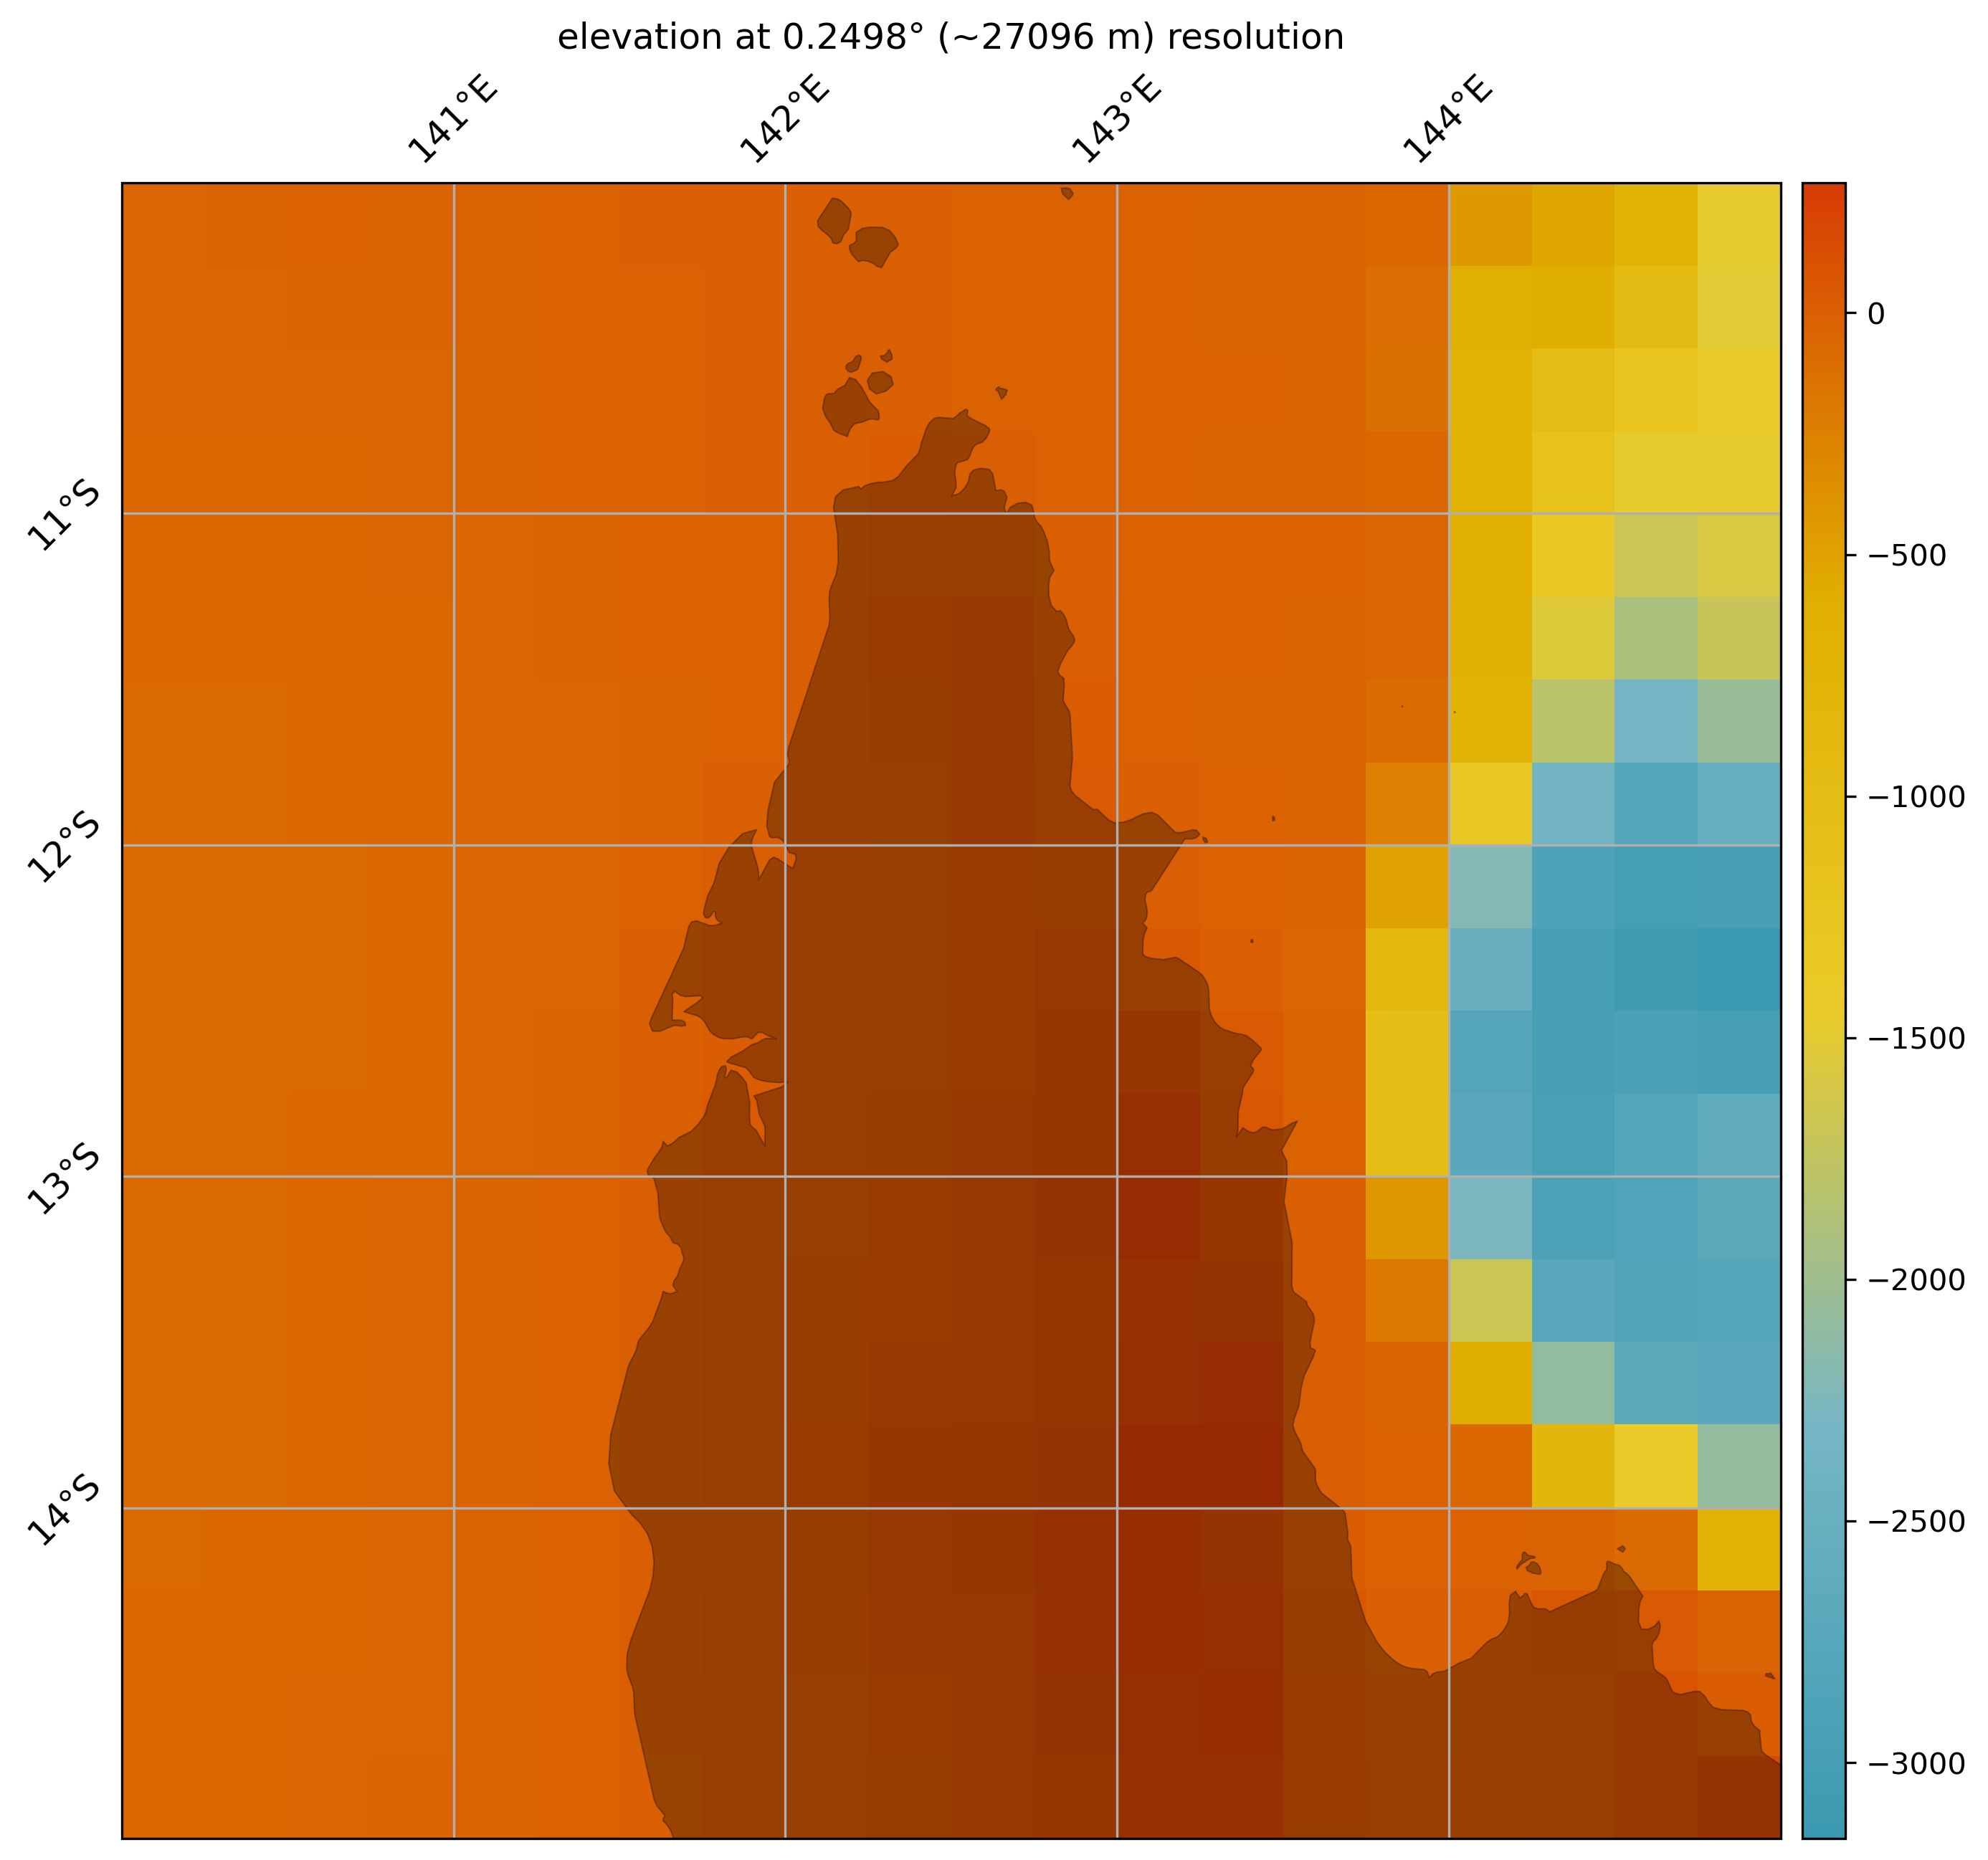

In [68]:
plotting.plot_spatial(resample_to_other(hr_rio_xa, lr_rio_xa))

20 20


(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.2498° (~27096 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x2e63e0350>)

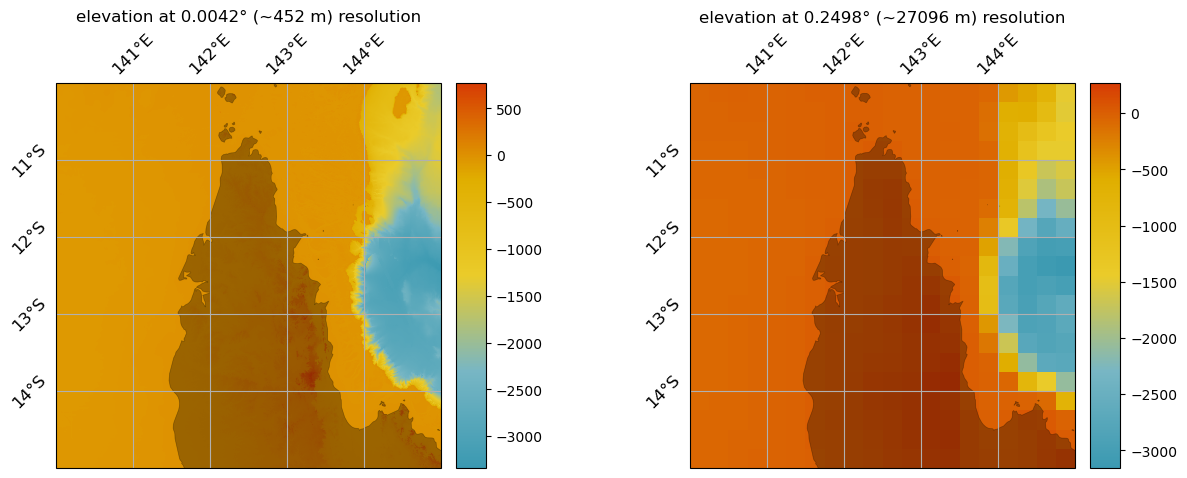

In [61]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(hr_rio_xa, fax=(f,a[0]), cbar_dict={"cmap_type": "seq"})
plotting.plot_spatial(resample_to_other(hr_rio_xa, lr_rio_xa), fax=(f,a[1]), cbar_dict={"cmap_type": "seq"})

(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'tos at 0.0040° (~434 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x396709340>)

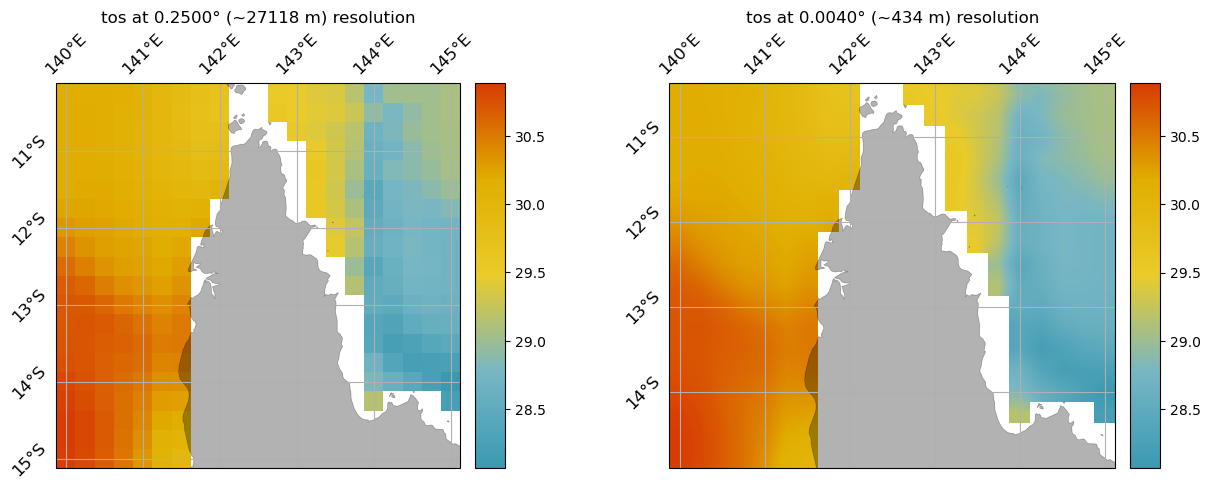

In [231]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(lr_rio_xa, fax=(f,a[0]), cbar_dict={"cmap_type": "seq"})
plotting.plot_spatial(process_resample_rasterio(lr_rio_xa, 0.004), fax=(f,a[1]), cbar_dict={"cmap_type": "seq"})

In [264]:
hr_xa

<xarray.Dataset> Size: 3MB
Dimensions:    (latitude: 1200, longitude: 1200)
Coordinates:
  * latitude   (latitude) float64 10kB -15.0 -14.99 -14.99 ... -10.01 -10.0
  * longitude  (longitude) float64 10kB 140.0 140.0 140.0 ... 145.0 145.0 145.0
    crs        int64 8B 0
Data variables:
    elevation  (latitude, longitude) int16 3MB -58 -58 -57 ... -1769 -1768 -1774
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.1000° (~10847 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x301f40380>)

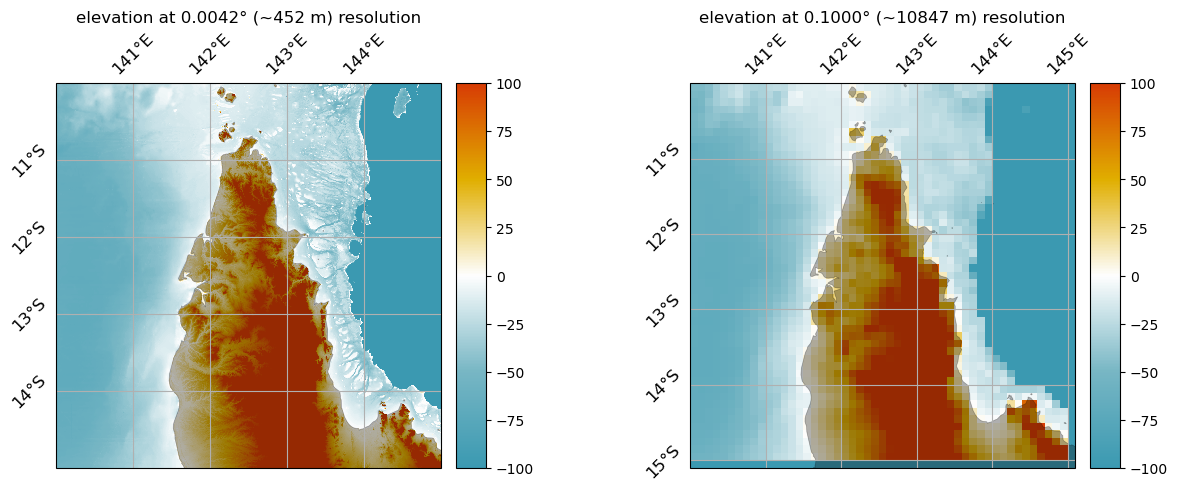

In [265]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(hr_xa.elevation, fax=(f,a[0]), cbar_dict={"cmap_type": "div"}, val_lims=[-100,100])
plotting.plot_spatial(process_resample_rasterio(hr_xa.elevation, 0.1), fax=(f,a[1]), cbar_dict={"cmap_type": "div"}, val_lims=[-100,100])

### Coral

## Upsampling

In [41]:
scale_factor = calc_scale_factor(np.mean(utils.calculate_spatial_resolution(lr_rio_xa)), np.mean(utils.calculate_spatial_resolution(hr_rio_xa)))

if scale_factor > 1:
    new_width = round(lr_rio_xa.rio.width * scale_factor)
    new_height = round(lr_rio_xa.rio.height * scale_factor)
else:
    new_width = round(lr_rio_xa.rio.width / scale_factor)
    new_height = round(lr_rio_xa.rio.height / scale_factor)

# set crs
lr_rio_xa.rio.set_crs("EPSG:4326")


21 20
0.016666666666666677 1260 1200


In [43]:
lr_rio_xa_upsampled = utils.process_xa_d(lr_rio_xa.rio.reproject(
    lr_rio_xa.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
))


(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'tos at 0.0040° (~431 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x2bb572360>)

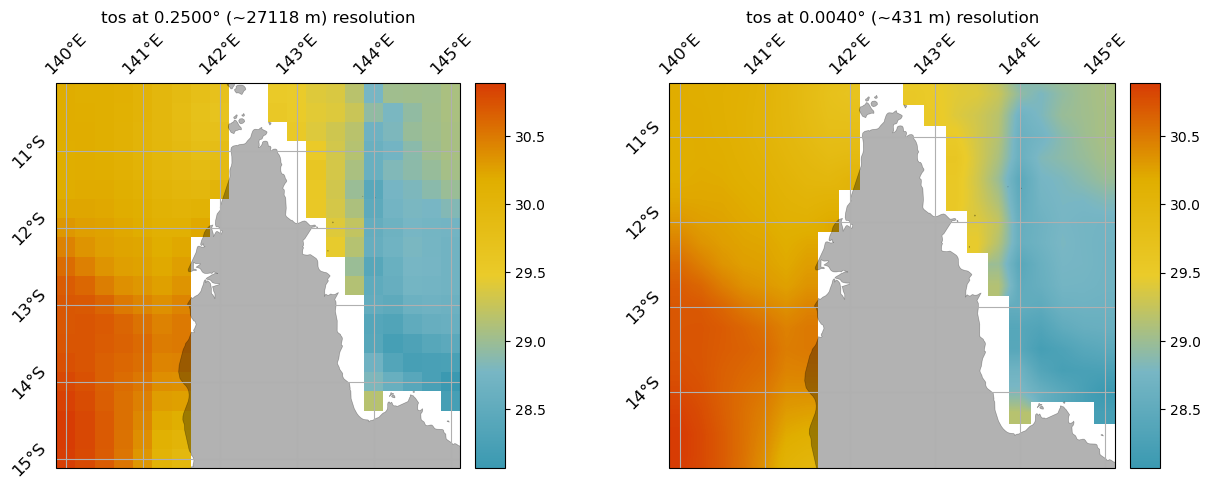

In [48]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(lr_rio_xa, fax=(f,a[0]), cbar_dict={"cmap_type": "seq"})
plotting.plot_spatial(lr_rio_xa_upsampled, fax=(f,a[1]), cbar_dict={"cmap_type": "seq"})

In [81]:
params_dict["method"][0].name

'nearest'

In [126]:
# time resampling method

# as size of array, as number of arrays, as scaling factor
import time

repeats = 10

params_dict = {
    "method": [Resampling.nearest, Resampling.bilinear, Resampling.cubic, Resampling.cubic_spline, Resampling.lanczos, Resampling.average, Resampling.mode, Resampling.med, Resampling.sum],
    "resolutions": [0.004, 0.01, 0.25, 0.5, 0.75, 1],
}


method_res_timings = {
    method.name: {res: {"total_time": 0, "iteration_time": 0} for res in params_dict["resolutions"]}
    for method in params_dict["method"]
}

for method in params_dict["method"]:
    for res in params_dict["resolutions"]:
        tic = time.time()
        for rep in range(repeats):
            process_resample_rasterio(lr_rio_xa, lat_resolution=res, lon_resolution=res, resampling_method=method)

        total_time = time.time() - tic
        method_res_timings[method.name][res]["total_time"] = total_time
        method_res_timings[method.name][res]["iteration_time"] = total_time / repeats

In [319]:
params_dict = {
    "method": [Resampling.nearest, Resampling.bilinear, Resampling.cubic, Resampling.cubic_spline, Resampling.lanczos, Resampling.average, Resampling.mode, Resampling.med, Resampling.sum],
    "resolutions": [
        0.001, 0.004, 0.008, 0.01, 0.012, 0.012531328320802004, 
    0.1, 
    0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
    ]
    ,
}

def random_sample_to_smaller(xa_d1, xa_d2):
    num_els_1 = len(xa_d1.values.flatten())
    num_els_2 = len(xa_d2.values.flatten())

    return np.random.choice(xa_d2.values.flatten(), size=num_els_1, replace=False)


def do_wilcoxon(xa_d, resampled):

    if len(resampled.values.flatten()) >= len(xa_d.values.flatten()):
        same_num_array = random_sample_to_smaller(xa_d, resampled)
        return sstats.wilcoxon(xa_d.values.flatten(), same_num_array)
    else:
        same_num_array = random_sample_to_smaller(resampled, xa_d)
        return sstats.wilcoxon(resampled.values.flatten(), same_num_array)
        

# def do_chi2(xa_d, resampled):

#     if len(resampled.values.flatten()) >= len(xa_d.values.flatten()):
#         same_num_array = random_sample_to_smaller(xa_d, resampled)
#         return sstats.chisquare(xa_d.values.flatten(), same_num_array)
#     else:
#         same_num_array = random_sample_to_smaller(resampled, xa_d)
#         return sstats.chisquare(resampled.values.flatten(), same_num_array)
        


method_res_stats = {
    method.name: {res: {} for res in params_dict["resolutions"]}
    for method in params_dict["method"]
}

for method in params_dict["method"]:
    for res in params_dict["resolutions"]:
        resampled = process_resample_rasterio(hr_xa, lat_resolution=res, lon_resolution=res, resampling_method=method)
        resampled_normed = resampled / resampled.max()

        ks_stats_result = sstats.kstest(hr_xa.values.flatten(), resampled_normed.values.flatten())
        wc_stats_result = do_wilcoxon(hr_xa, resampled_normed)
        mwu_stats_result = sstats.mannwhitneyu(hr_xa.values.flatten(), resampled_normed.values.flatten())
        # chi2_stats_result = do_chi2(hr_xa, resampled_normed)

        # Wilcoxon test
        method_res_stats[method.name][res]["wc_statistic"] = wc_stats_result.statistic
        method_res_stats[method.name][res]["wc_pvalue"] = wc_stats_result.pvalue
        # Kolmogorov-Smirnov test
        method_res_stats[method.name][res]["ks_statistic"] = stats_result.statistic
        method_res_stats[method.name][res]["ks_pvalue"] = stats_result.pvalue
        method_res_stats[method.name][res]["ks_statistic_location"] = stats_result.statistic_location
        method_res_stats[method.name][res]["ks_statistic_sign"] = stats_result.statistic_sign
        # Mann-Whitney U test
        method_res_stats[method.name][res]["mwu_statistic"] = stats_result.statistic
        method_res_stats[method.name][res]["mwu_pvalue"] = stats_result.pvalue
        method_res_stats[method.name][res]["array"] = resampled_normed
        # Chi-squared test doesn't work: 
        # ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies 
        # to a relative tolerance of 1e-08, but the percent differences are:
        # method_res_stats[method.name][res]["chi2_statistic"] = stats_result.statistic
        # method_res_stats[method.name][res]["chi2_pvalue"] = stats_result.pvalue


(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'None at 1.0025° (~108746 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x348713e00>)

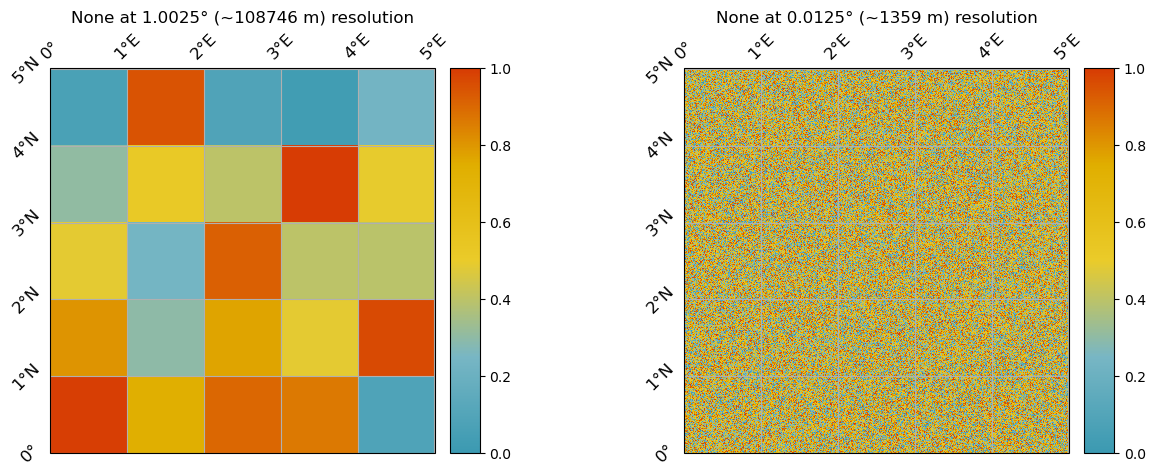

In [331]:
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(hr_xa, fax=(f,a[1]), cbar_dict={"cmap_type": "seq"}, val_lims=[0,1])
plotting.plot_spatial(method_res_stats["nearest"][1]["array"], fax=(f,a[0]), cbar_dict={"cmap_type": "seq"}, val_lims=[0,1])


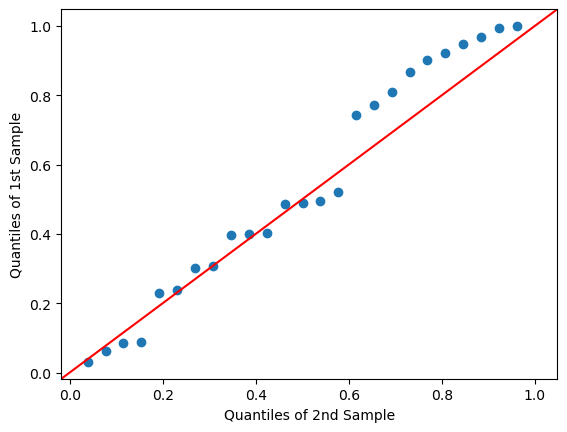

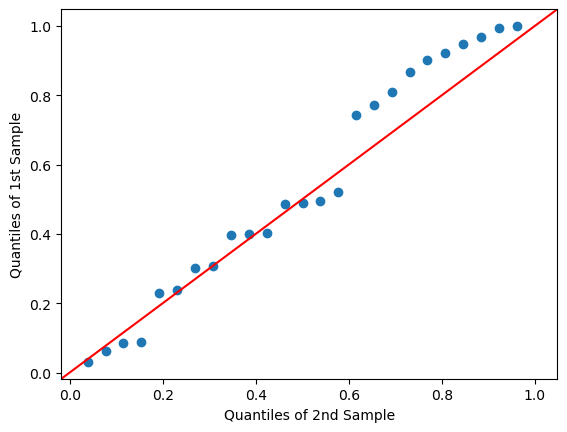

In [332]:
from statsmodels.graphics.gofplots import qqplot_2samples


f, a = plt.subplots()
qqplot_2samples(method_res_stats["nearest"][1]["array"].values.flatten(), hr_xa.values.flatten(), ax=a, line="45")


In [263]:
hr_xa.rio.resolution()

(0.012531328320802004, 0.012531328320802004)

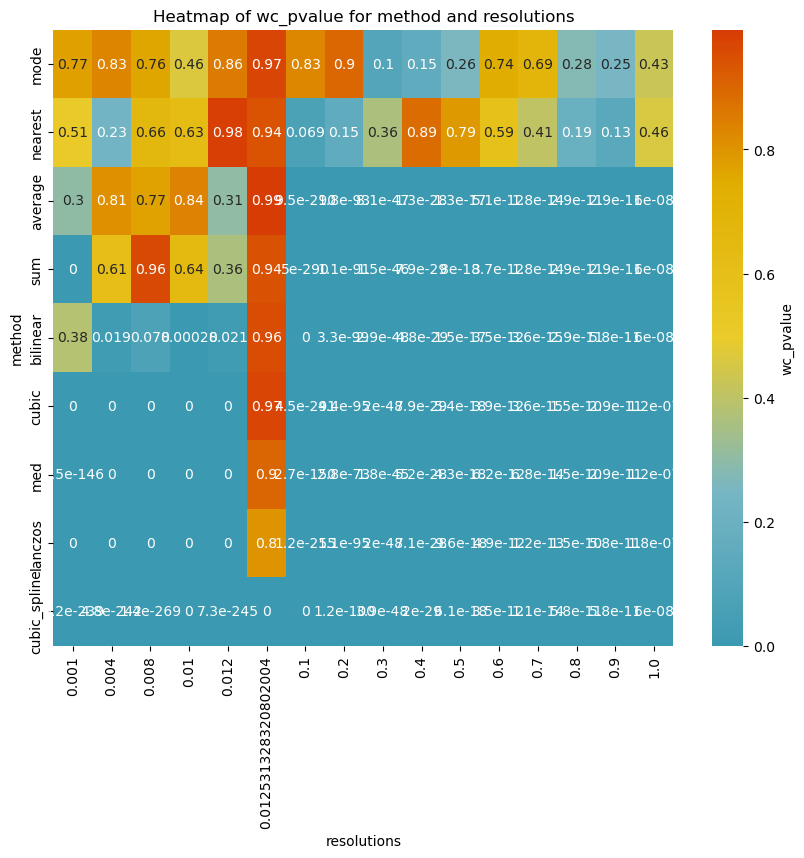

In [318]:
plot_heatmap_from_dict_pairs(method_res_stats, "wc_pvalue", "method", "resolutions")

In [269]:
import scipy.stats as sstats

# dist1 = lr_xa
print(sstats.wilcoxon(lr_xa.values.flatten(), hr_xa.values.flatten()[:400]))
# print(sstats.kstest(lr_xa.values.flatten(), lr_xa.values.flatten()))
# sstats.kstest(lr_xa.values.flatten(), lr_xa.values.flatten())[0]

WilcoxonResult(statistic=37510.0, pvalue=0.2629677258433709)


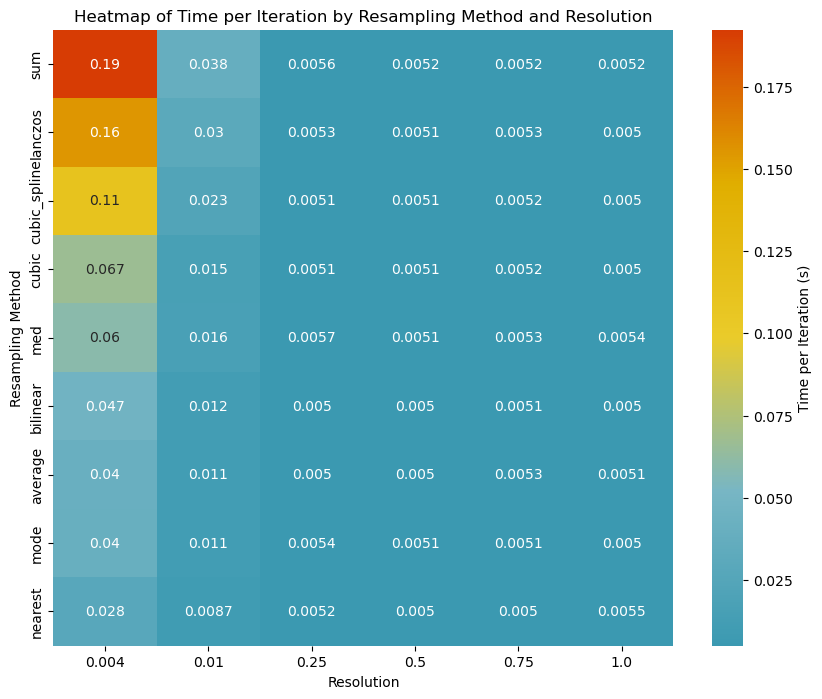

In [127]:
import pandas as pd
import seaborn as sns
# Calculate average iteration time for each method
average_iteration_times = {
    method: np.mean([method_res_timings[method][res]["iteration_time"] for res in params_dict["resolutions"]])
    for method in method_res_timings.keys()
}

# Sort methods by average iteration time
sorted_methods = sorted(average_iteration_times, key=average_iteration_times.get)[::-1]

# Prepare data for heatmap in the sorted order
heatmap_data = []
for method in sorted_methods:
    row = []
    for res in params_dict["resolutions"]:
        row.append(method_res_timings[method][res]["iteration_time"])
    heatmap_data.append(row)

# Convert to a pandas DataFrame for easier plotting
heatmap_df = pd.DataFrame(
    heatmap_data, 
    index=sorted_methods, 
    columns=params_dict["resolutions"]
)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=plotting.ColourMapGenerator().get_cmap("seq"), cbar_kws={'label': 'Time per Iteration (s)'})
plt.title('Heatmap of Time per Iteration by Resampling Method and Resolution')
plt.xlabel('Resolution')
plt.ylabel('Resampling Method')
plt.show()

In [217]:
# as scaling factor, size of array

# seems 10 is plenty to get similar results
repeats = 10


params_dict = {
    "method": [Resampling.nearest, Resampling.bilinear, Resampling.cubic, Resampling.cubic_spline, Resampling.lanczos, Resampling.average, Resampling.mode, Resampling.med, Resampling.sum],
    "resolutions": [0.004, 0.01, 0.25, 0.5, 0.75, 1],
    "proportions": np.linspace(0.1, 1, 20),
}

lr_resolution_proportion_timings = {
    res: {
        prop: {
                "total_time": 0,
                "iteration_time": 0,
            }
        for prop in params_dict["proportions"]
    } for res in params_dict["resolutions"]
}


from tqdm.auto import tqdm

for proportion in tqdm(params_dict["proportions"]):
    for res in tqdm(params_dict["resolutions"]):
        # raster = whole_lr_xa.isel(latitude=slice(0, round(whole_lr_xa.latitude.size * proportion)), longitude=slice(0, round(whole_lr_xa.longitude.size * proportion)))
        raster = hr_xa.isel(latitude=slice(0, round(whole_lr_xa.latitude.size * proportion)), longitude=slice(0, round(whole_lr_xa.longitude.size * proportion)))
        tic = time.time()
        for rep in range(repeats):
            try:
                process_resample_rasterio(raster, lat_resolution=res, lon_resolution=res, resampling_method=Resampling.sum)
            except ValueError:
                continue

        total_time = time.time() - tic
        lr_resolution_proportion_timings[res][proportion]["total_time"] = total_time
        lr_resolution_proportion_timings[res][proportion]["iteration_time"] = total_time / repeats

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


In [223]:
import scipy.stats as sstats

# dist1 = lr_xa
print(sstats.kstest(lr_xa.values.flatten(), hr_xa.values.flatten()))
print(sstats.kstest(lr_xa.values.flatten(), lr_xa.values.flatten()))

KstestResult(statistic=0.02486250000000001, pvalue=0.960894480662965, statistic_location=0.9166622156705855, statistic_sign=-1)
KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.0021405571114617716, statistic_sign=1)


In [ ]:
stats_results = 



for proportion in tqdm(params_dict["proportions"]):
    for res in tqdm(params_dict["resolutions"]):
        # raster = whole_lr_xa.isel(latitude=slice(0, round(whole_lr_xa.latitude.size * proportion)), longitude=slice(0, round(whole_lr_xa.longitude.size * proportion)))
        raster = hr_xa.isel(latitude=slice(0, round(whole_lr_xa.latitude.size * proportion)), longitude=slice(0, round(whole_lr_xa.longitude.size * proportion)))
        # tic = time.time()
        for rep in range(repeats):
            try:
                resampled = process_resample_rasterio(raster, lat_resolution=res, lon_resolution=res, resampling_method=Resampling.sum)
            except ValueError:
                continue

        
        print(sstats.kstest(lr_xa.values.flatten(), hr_xa.values.flatten()))
        print(sstats.kstest(lr_xa.values.flatten(), lr_xa.values.flatten()))

        total_time = time.time() - tic
        lr_resolution_proportion_timings[res][proportion]["total_time"] = total_time
        lr_resolution_proportion_timings[res][proportion]["iteration_time"] = total_time / repeats

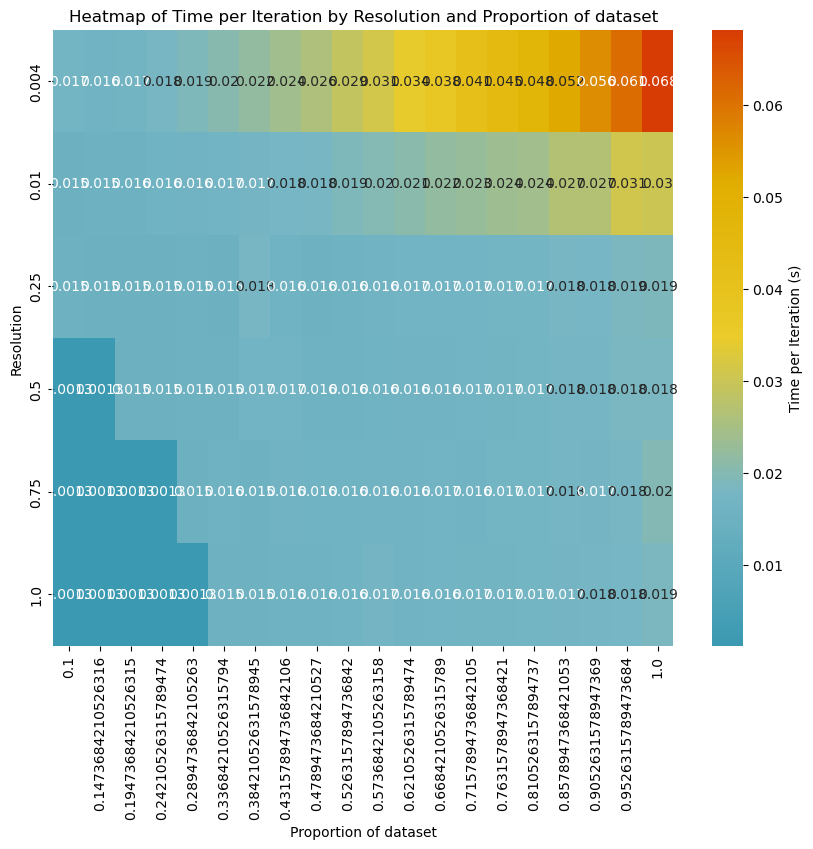

In [218]:
plot_timing_heatmap_from_dict_pairs(lr_resolution_proportion_timings, "Resolution", "Proportion of dataset")

In [178]:

hr_resolution_proportion_timings = {
    res: {
        prop: {
                "total_time": 0,
                "iteration_time": 0,
            }
        for prop in params_dict["proportions"]
    } for res in params_dict["resolutions"]
}


from tqdm.auto import tqdm

for proportion in tqdm(params_dict["proportions"]):
    for res in tqdm(params_dict["resolutions"]):
        raster = whole_lr_xa.isel(latitude=slice(0, round(whole_hr_xa.latitude.size * proportion)), longitude=slice(0, round(whole_lr_xa.longitude.size * proportion)))
        tic = time.time()
        for rep in range(repeats):
            process_resample_rasterio(raster, lat_resolution=res, lon_resolution=res, resampling_method=Resampling.sum)

        total_time = time.time() - tic
        hr_resolution_proportion_timings[res][proportion]["total_time"] = total_time
        hr_resolution_proportion_timings[res][proportion]["iteration_time"] = total_time / repeats

100%|██████████| 5/5 [04:18<00:00, 51.72s/it]


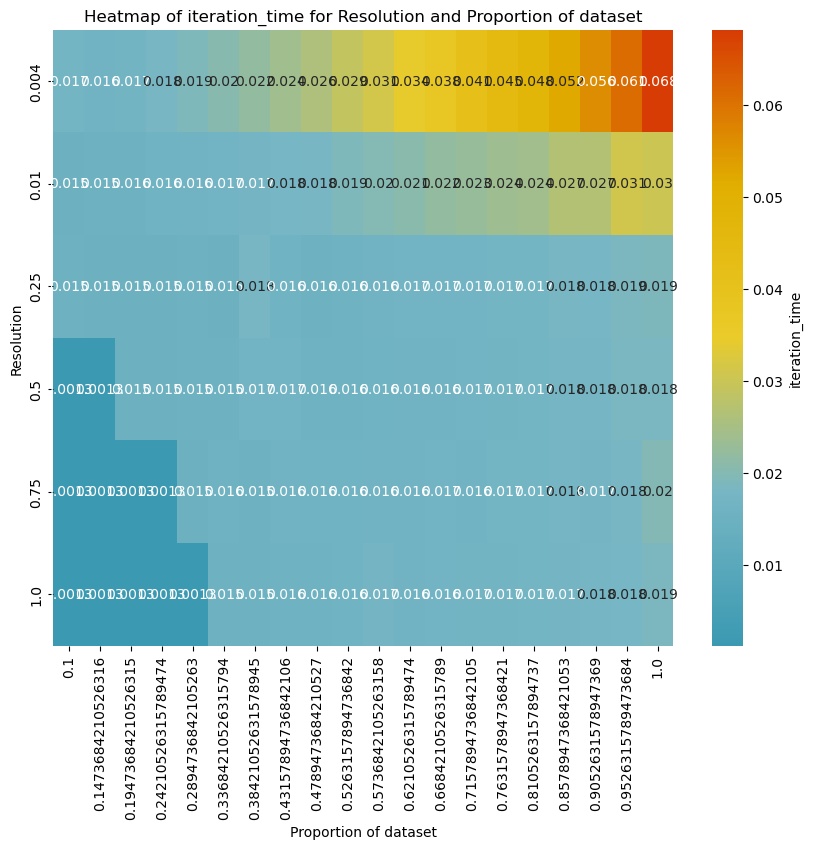

In [249]:
def plot_heatmap_from_dict_pairs(dictionary: dict, statistic: str, key1: str="key 1", key2: str="key 2", cbar_label: str=None):
    av_iteration_times = {
        k1: np.mean([dictionary[k1][k2][statistic] for k2 in dictionary[k1].keys()])
        for k1 in dictionary.keys()
    }
    sorted_data = sorted(av_iteration_times, key=av_iteration_times.get)[::-1]

    heatmap_data = []
    for k1 in sorted_data:
        row = []
        for k2 in dictionary[k1].keys():
            row.append(dictionary[k1][k2][statistic])
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(
        heatmap_data,
        index=sorted_data,
        columns=dictionary[sorted_data[0]].keys()
    )

    plt.figure(figsize=(10, 8))

    if not cbar_label:
        cbar_label = statistic

    sns.heatmap(heatmap_df, annot=True, cmap=plotting.ColourMapGenerator().get_cmap("seq"), cbar_kws={'label': cbar_label})
    plt.title(f'Heatmap of {statistic} for {key1} and {key2}')
    plt.xlabel(key2)
    plt.ylabel(key1)
    plt.show()

plot_heatmap_from_dict_pairs(lr_resolution_proportion_timings, "iteration_time", "Resolution", "Proportion of dataset")

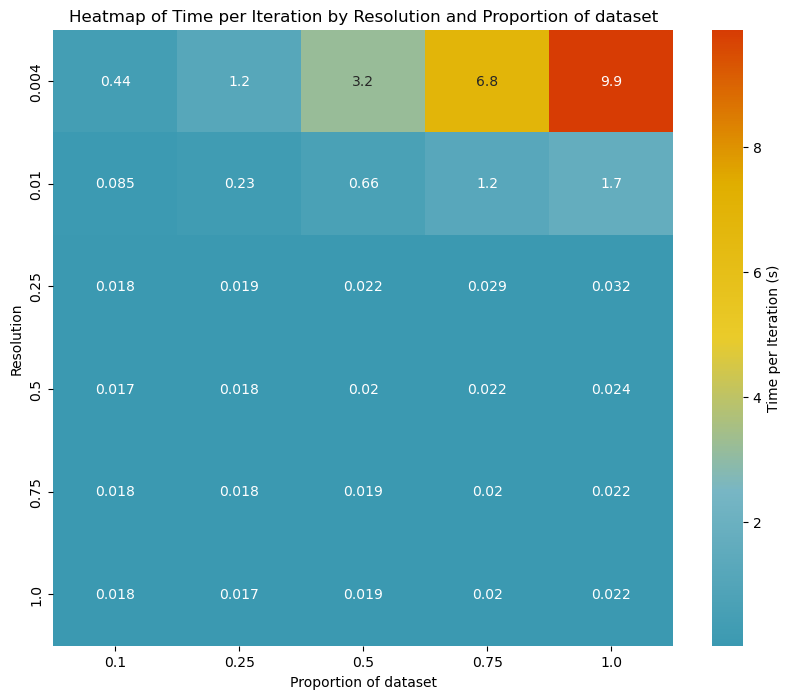

In [181]:
plot_timing_heatmap_from_dict_pairs(hr_resolution_proportion_timings, "Resolution", "Proportion of dataset")

In [185]:
hr_resolution_proportion_timings

{0.004: {0.1: {'total_time': 4.359130144119263,
   'iteration_time': 0.43591301441192626},
  0.25: {'total_time': 11.935322046279907,
   'iteration_time': 1.1935322046279908},
  0.5: {'total_time': 31.87282085418701, 'iteration_time': 3.187282085418701},
  0.75: {'total_time': 68.46851515769958, 'iteration_time': 6.846851515769958},
  1: {'total_time': 98.77643966674805, 'iteration_time': 9.877643966674805}},
 0.01: {0.1: {'total_time': 0.8456549644470215,
   'iteration_time': 0.08456549644470215},
  0.25: {'total_time': 2.2965590953826904,
   'iteration_time': 0.22965590953826903},
  0.5: {'total_time': 6.562819242477417, 'iteration_time': 0.6562819242477417},
  0.75: {'total_time': 12.204399824142456,
   'iteration_time': 1.2204399824142456},
  1: {'total_time': 17.09029507637024, 'iteration_time': 1.7090295076370239}},
 0.25: {0.1: {'total_time': 0.17585206031799316,
   'iteration_time': 0.017585206031799316},
  0.25: {'total_time': 0.19307708740234375,
   'iteration_time': 0.019307

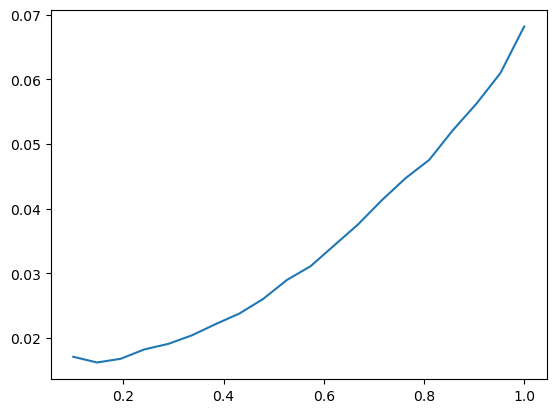

In [219]:
# plot itertaion time by proportion for resolution 0.004

vals = [lr_resolution_proportion_timings[0.004][prop]["iteration_time"] for prop in lr_resolution_proportion_timings[0.004].keys()]

plt.plot(params_dict["proportions"], vals)

In [ ]:
import pandas as pd
import seaborn as sns
# Calculate average iteration time for each method
average_iteration_times = {
    method: np.mean([resolution_proportions_timings[res][proportion]["iteration_time"] for res in params_dict["resolutions"]])
    for method in resolution_proportions_timings.keys()
}

# Sort methods by average iteration time
sorted_methods = sorted(average_iteration_times, key=average_iteration_times.get)[::-1]

# Prepare data for heatmap in the sorted order
heatmap_data = []
for method in sorted_methods:
    row = []
    for res in params_dict["resolutions"]:
        row.append(resolution_proportions_timings[method][res]["iteration_time"])
    heatmap_data.append(row)

# Convert to a pandas DataFrame for easier plotting
heatmap_df = pd.DataFrame(
    heatmap_data, 
    index=sorted_methods, 
    columns=params_dict["resolutions"]
)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=plotting.ColourMapGenerator().get_cmap("seq"), cbar_kws={'label': 'Time per Iteration (s)'})
plt.title('Heatmap of Time per Iteration by Resampling Method and Resolution')
plt.xlabel('Resolution')
plt.ylabel('Resampling Method')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
# Calculate average iteration time for each method
average_iteration_times = {
    method: np.mean([method_res_timings[res][proportion]["iteration_time"] for res in params_dict["resolutions"]])
    for method in method_res_timings.keys()
}

# Sort methods by average iteration time
sorted_methods = sorted(average_iteration_times, key=average_iteration_times.get)[::-1]

# Prepare data for heatmap in the sorted order
heatmap_data = []
for method in sorted_methods:
    row = []
    for res in params_dict["resolutions"]:
        row.append(method_res_timings[method][res]["iteration_time"])
    heatmap_data.append(row)

# Convert to a pandas DataFrame for easier plotting
heatmap_df = pd.DataFrame(
    heatmap_data, 
    index=sorted_methods, 
    columns=params_dict["resolutions"]
)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=plotting.ColourMapGenerator().get_cmap("seq"), cbar_kws={'label': 'Time per Iteration (s)'})
plt.title('Heatmap of Time per Iteration by Resampling Method and Resolution')
plt.xlabel('Resolution')
plt.ylabel('Resampling Method')
plt.show()

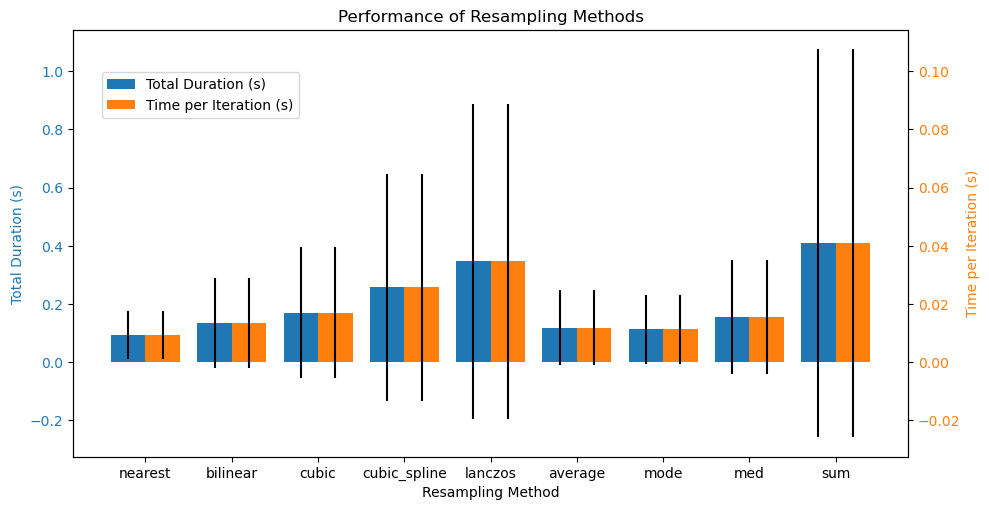

In [113]:
import matplotlib.pyplot as plt
import numpy as np

methods = [k for k in timings.keys()]
total_times = [np.mean([timings[method][res]["total_time"] for res in params_dict["resolutions"]]) for method in methods]
iteration_times = [np.mean([timings[method][res]["iteration_time"] for res in params_dict["resolutions"]]) for method in methods]


# Calculating variances if not provided
total_times_var = [np.std([timings[method][res]["total_time"] for res in params_dict["resolutions"]]) for method in methods]
iteration_times_var = [np.std([timings[method][res]["iteration_time"] for res in params_dict["resolutions"]]) for method in methods]


x = np.arange(len(methods))  # Label locations

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting the total duration
ax1.set_xlabel('Resampling Method')
ax1.set_ylabel('Total Duration (s)', color='tab:blue')
bars1 = ax1.bar(x - 0.2, total_times, width=0.4, label='Total Duration (s)', yerr=total_times_var, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

# Creating twin axes for iteration times
ax2 = ax1.twinx()
ax2.set_ylabel('Time per Iteration (s)', color='tab:orange')
bars2 = ax2.bar(x + 0.2, iteration_times, width=0.4, label='Time per Iteration (s)', yerr=iteration_times_var, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()  # Adjust layout to make room for both y-axes

# Adding legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
# Displaying the plot
plt.title('Performance of Resampling Methods')
plt.show()


In [102]:
timings

{'nearest': {'total_time': 0.1931929588317871,
  'time_per_iteration': 0.01931929588317871},
 'bilinear': {'total_time': 0.35358119010925293,
  'time_per_iteration': 0.035358119010925296},
 'cubic': {'total_time': 0.5433359146118164,
  'time_per_iteration': 0.05433359146118164},
 'cubic_spline': {'total_time': 0.9528017044067383,
  'time_per_iteration': 0.09528017044067383},
 'lanczos': {'total_time': 1.3440771102905273,
  'time_per_iteration': 0.13440771102905275},
 'average': {'total_time': 0.305513858795166,
  'time_per_iteration': 0.030551385879516602},
 'mode': {'total_time': 0.2733490467071533,
  'time_per_iteration': 0.02733490467071533}}

## Problem cases


(<Figure size 1500x500 with 4 Axes>,
 <GeoAxes: title={'center': 'unep_coral_presence at 0.1000° (~10848 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x3478bba40>)

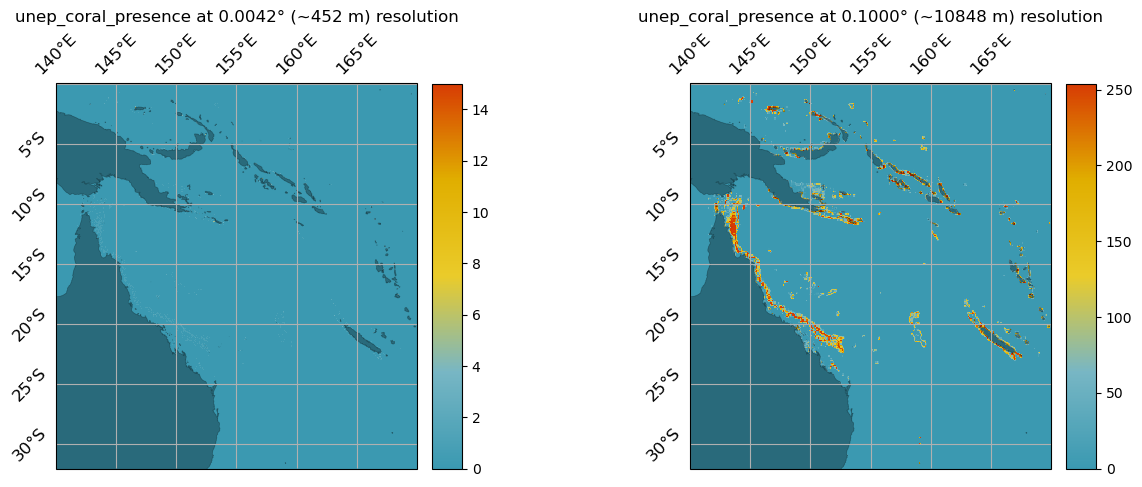

In [125]:
# unep_xa = utils.process_xa_d(rioxarray.open_rasterio(unep_fp)).sel(longitude=slice(min(LONS), max(LONS)), latitude=slice(min(LATS), max(LATS))).rio.set_crs("EPSG:4326")
f, a = plt.subplots(ncols=2, figsize=[15, 5], subplot_kw={"projection": ccrs.PlateCarree()})

plotting.plot_spatial(whole_unep_xa, fax=(f,a[0]), cbar_dict={"cmap_type": "seq"})
plotting.plot_spatial(process_resample_rasterio(whole_unep_xa, 0.1, 0.1, resampling_method=Resampling.sum), fax=(f,a[1]), cbar_dict={"cmap_type": "seq"})


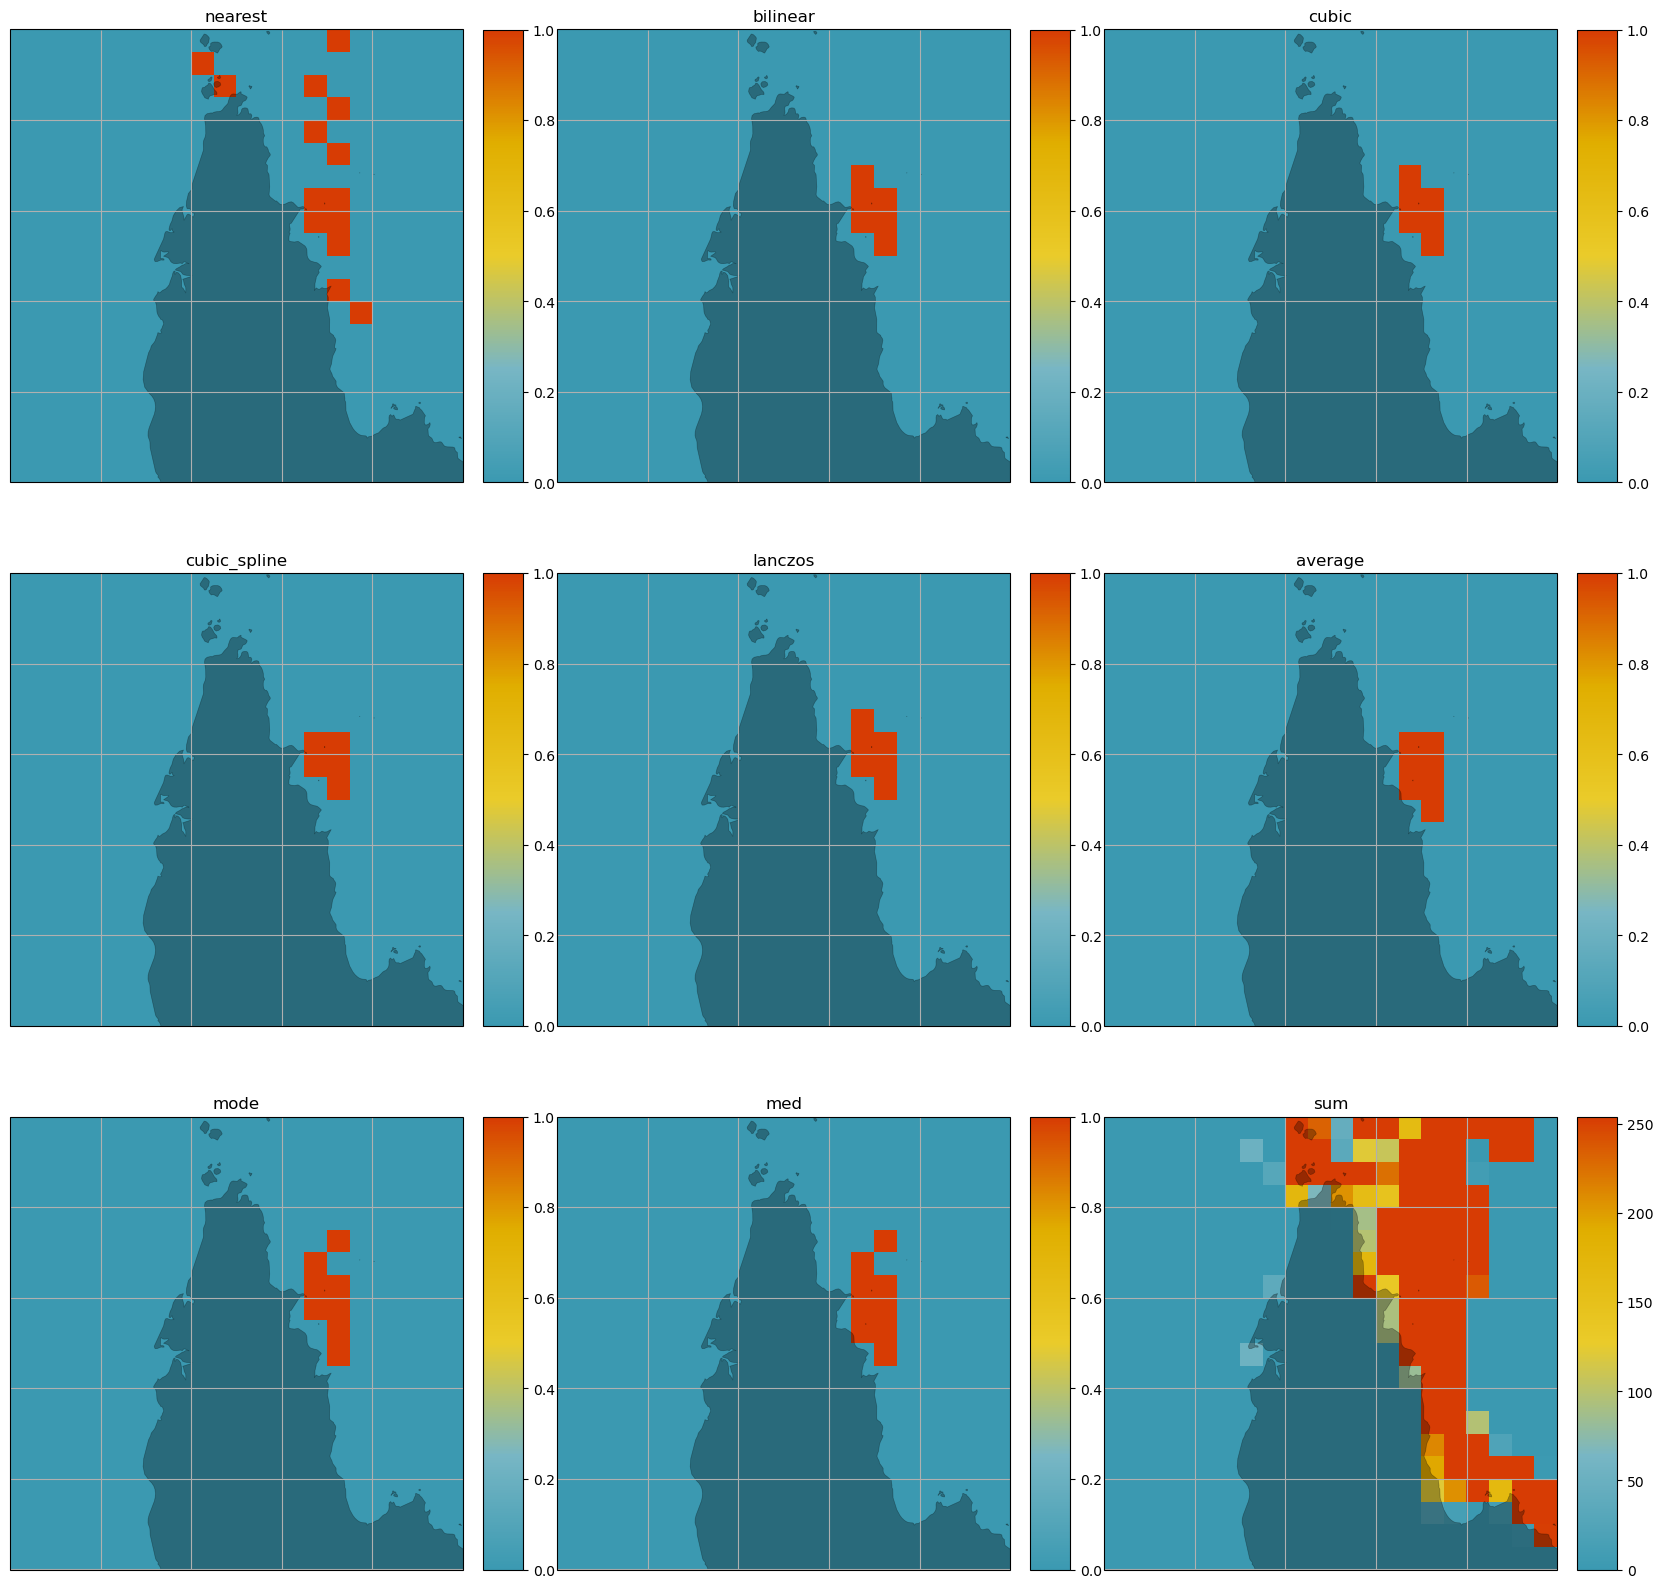

In [120]:
resample_methods = [Resampling.nearest, Resampling.bilinear, Resampling.cubic, Resampling.cubic_spline, Resampling.lanczos, Resampling.average, Resampling.mode, Resampling.med, Resampling.sum]

f, axes = plt.subplots(nrows=len(resample_methods)//3, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[20,20])

for i, method in enumerate(resample_methods):
    ax = axes.ravel()[i]
    # plotting.plot_spatial(process_resample_rasterio(unep_xa, 0.1, resampling_method=method), fax=(f,ax), cbar_dict={"cmap_type": "seq"}, title=method.name,labels=False)
    plotting.plot_spatial(resample_to_other(unep_xa, lr_rio_xa, resampling_method=method), fax=(f,ax), cbar_dict={"cmap_type": "seq"}, title=method.name,labels=False)

# Pyresample

Hella involved: https://pyresample.readthedocs.io/en/latest/howtos/grid.html

In [50]:
import dask.array as da
# from xarray import DataArray
from pyresample.bilinear import XArrayBilinearResampler
from pyresample import geometry


target_def = geometry.AreaDefinition('areaD',
                                     'Europe (3km, HRV, VTC)',
                                     'areaD',
                                     {'a': '6378144.0', 'b': '6356759.0',
                                      'lat_0': '50.00', 'lat_ts': '50.00',
                                      'lon_0': '8.00', 'proj': 'stere'},
                                     800, 800,
                                     [-1370912.72, -909968.64,
                                      1029087.28, 1490031.36])


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_62044/2790322125.py:3: UserWarning: XArray, dask, and/or zarr not found, XArrayBilinearResampler won't be available.
  from pyresample.bilinear import XArrayBilinearResampler


In [68]:
data = xa.DataArray(da.from_array(np.fromfunction(lambda y, x: y*x, (500, 100))), dims=('y', 'x'))
data2 = lr_rio_xa_upsampled.chunk({"latitude": 100, "longitude": 100})
# lons = da.from_array(np.fromfunction(lambda y, x: 3 + x * 0.1, (500, 100)))
# lats = da.from_array(np.fromfunction(lambda y, x: 75 - y * 0.1, (500, 100)))

lons = data2.longitude.chunk({"longitude": 10})
lats = data2.latitude.chunk({"latitude": 10})
source_def = geometry.SwathDefinition(lons=lons, lats=lats)
# resampler = XArrayBilinearResampler(source_def, target_def, 30e3)
# result = resampler.resample(data)

lons

ValueError: lons and lats must have same shape

# CDO (python-cdo)